In [1]:
import os
import math
from tqdm import tqdm
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR
import threestudio
import gc
import time
import io
import cv2
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, Output
from IPython.display import display, clear_output
from PIL import Image
from torchvision.transforms import ToTensor

def get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps, num_cycles: float = 0.5):

    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress)))

    return LambdaLR(optimizer, lr_lambda, -1)

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
# To specify the gpu you want to use, we recommend to start the jupyter server with CUDA_VISIBLE_DEVICES=<gpu_ids>.
# threestudio.utils.base.get_device = lambda: torch.device('cuda:0') # hack the cuda device

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# prompt = "A partial view photo of a chinese style living room"
prompt = "Stormtrooper, lecture realistic"
print(prompt)

Stormtrooper, lecture realistic


In [3]:
# stable diffusion 
config = {
    'max_iters': 5000,
    'seed': 42,
    'scheduler': 'cosine',
    'mode': 'latent',
    'prompt_processor_type': 'stable-diffusion-prompt-processor',
    'prompt_processor': {
        'prompt': prompt,
    },
    'guidance_type': 'depth-controlnet-SD1.5-guidance',
    'guidance': {
        'half_precision_weights': True,
        'guidance_scale': 100,
        'pretrained_model_name_or_path': '/remote-home/share/Models/runwayml/stable-diffusion-v1-5',
        'controlnet_name_or_path': "/remote-home/share/Models/lllyasviel/control_v11f1p_sd15_depth",
        'grad_clip': [0, 1.5, 2.0, 1000],
        
    },
    'image': {
        'width': 64,
        'height': 64,
    }
}
seed_everything(config['seed'])

In [3]:
# stable diffusion XL
config = {
    'max_iters': 5000,
    'seed': 42,
    'scheduler': 'cosine',
    'mode': 'latent',
    'prompt_processor_type': 'stable-diffusion-xl-prompt-processor',
    'prompt_processor': {
        'prompt': prompt,
        'prompt_2': prompt,
        'negative_prompt': "unrealistic",
        'negative_prompt_2': "unrealistic"
    },
    'guidance_type': 'stable-diffusion-xl-depth-controlnet-guidance',
    'guidance': {
        'half_precision_weights': True,
        'guidance_scale': 7.5,
        'pretrained_model_name_or_path': "/remote-home/share/Models/stabilityai/stable-diffusion-xl-base-1.0" ,
        # 'controlnet_name_or_path': "/remote-home/share/Models/diffusers/controlnet-depth-sdxl-1.0",
        'controlnet_name_or_path': "/remote-home/share/Models/diffusers/controlnet-zoe-depth-sdxl-1.0",
        'vae_pretrained_path': "/remote-home/share/Models/madebyollin/sdxl-vae-fp16-fix",
        'grad_clip': [0, 1.5, 2.0, 1000],
        
    },
    'image': {
       'width': 128,
       'height': 128,
    }
    # 'image': {
    #     'width': 1024,
    #     'height': 1024,
    # }
}
seed_everything(config['seed'])

In [4]:
# just need to rerun the cell when you change guidance or prompt_processor
guidance = None
prompt_processor = None
gc.collect()
with torch.no_grad():
    torch.cuda.empty_cache()

guidance = threestudio.find(config['guidance_type'])(config['guidance'])
prompt_processor = threestudio.find(config['prompt_processor_type'])(config['prompt_processor'])
prompt_processor.configure_text_encoder()

Loading Stable Diffusion XL ControlNet ...
Loaded Stable Diffusion XL ControlNet!
Using prompt:
 prompt_1: [Stormtrooper, lecture realistic], 
 prompt_2: [Stormtrooper, lecture realistic]; 
 negative_prompt1: [unrealistic], 
 negative_prompt2: [unrealistic]


In [5]:
def figure2image(fig):
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)
    return img

def configure_other_guidance_params_manually(guidance, config):
    # avoid reloading guidance every time change these params
    guidance.cfg.grad_clip = config['guidance']['grad_clip']
    guidance.cfg.guidance_scale = config['guidance']['guidance_scale']

def run(config):
    # clear gpu memory
    rgb = None
    grad = None
    vis_grad = None
    vis_grad_norm = None
    loss = None
    optimizer = None
    target = None

    gc.collect()
    with torch.no_grad():
        torch.cuda.empty_cache()
    
    configure_other_guidance_params_manually(guidance, config)

    mode = config['mode']

    toTensor = ToTensor()
    # 1024
    depth_image = Image.open("/remote-home/hzp/test/sdxl_depth/controlnet-depth-sdxl-1.0/A_DSLR_photo_of_a_chinese_style_living_room,_view_from_ceil,_photorealistic_depth.png")
    depth_image = Image.open("/remote-home/hzp/test/sdxl_depth/controlnet-depth-sdxl-1.0-mid/stormtrooper_depth.png")
    # 512
    # depth_image = Image.open("/remote-home/hzp/test/t2i-adapter_room_gaussian_rendered_depth/1704196873_37492_depth.jpg")
    # depth_image = Image.open("")
    depth_image = toTensor(pic=depth_image) # 已经转化为[0, 1]
    depth_image = depth_image.unsqueeze(0).to(guidance.device) # HW -> BHW
    depth_image = depth_image.permute(0, 2, 3, 1) # BCHW -> BHWC
    
    w, h = config['image']['width'], config['image']['height']
    if mode == 'rgb':
        target = nn.Parameter(torch.rand(1, h, w, 3, device=guidance.device))
    else:
        target = nn.Parameter(torch.randn(1, h, w, 4, device=guidance.device))

    optimizer = torch.optim.AdamW([target], lr=1e-1, weight_decay=0)
    num_steps = config['max_iters']
    scheduler = get_cosine_schedule_with_warmup(optimizer, 100, int(num_steps*1.5)) if config['scheduler'] == 'cosine' else None

    rgb = None
    plt.axis('off')

    img_array = []

    try:
        for step in tqdm(range(num_steps + 1)):
            optimizer.zero_grad()

            batch = {
                'elevation': torch.Tensor([0]),
                'azimuth': torch.Tensor([0]),
                'camera_distances': torch.Tensor([1]),
            }

            loss = guidance(rgb=target, image_cond=depth_image, prompt_utils=prompt_processor(), **batch, rgb_as_latents=(mode != 'rgb'))
            loss['loss_sds'].backward()

            grad = target.grad
            optimizer.step()
            if scheduler is not None:
                scheduler.step()
            
            guidance.update_step(epoch=0, global_step=step)

            if step % 5 == 0:
                if mode == 'rgb':
                    rgb = target
                    vis_grad = grad[..., :3]
                    vis_grad_norm = grad.norm(dim=-1)
                else:
                    rgb = guidance.decode_latents(target.permute(0, 3, 1, 2)).permute(0, 2, 3, 1)
                    vis_grad = grad
                    vis_grad_norm = grad.norm(dim=-1)
                
                vis_grad_norm = vis_grad_norm / vis_grad_norm.max()
                vis_grad = vis_grad / vis_grad.max()
                img_rgb = rgb.clamp(0, 1).detach().squeeze(0).cpu().numpy()
                img_grad = vis_grad.clamp(0, 1).detach().squeeze(0).cpu().numpy()
                img_grad_norm = vis_grad_norm.clamp(0, 1).detach().squeeze(0).cpu().numpy()
                img_depth = depth_image.clamp(0, 1).detach().squeeze(0).cpu().numpy()
    
                fig, ax = plt.subplots(1, 4, figsize=(15, 5))
                ax[0].imshow(img_rgb)
                ax[1].imshow(img_grad)
                ax[2].imshow(img_grad_norm)
                ax[3].imshow(img_depth, cmap='gray')
                ax[0].axis('off')
                ax[1].axis('off')
                ax[2].axis('off')
                ax[3].axis('off')
                clear_output(wait=True)
                plt.show()
                img_array.append(figure2image(fig))
    except KeyboardInterrupt:
        pass
    finally:
        # browse the result
        print("Optimizing process:")
        images = img_array
        
        if len(images) > 0:
            # Set up the widgets
            slider = IntSlider(min=0, max=len(images)-1, step=1, value=1)
            output = Output()

            def display_image(index):
                with output:
                    output.clear_output(wait=True)
                    display(images[index])

            # Link the slider to the display function
            interact(display_image, index=slider)

            # Display the widgets
            # display(slider)
            display(output)

  0%|                                                               | 0/5001 [00:02<?, ?it/s]


Optimizing process:


OutOfMemoryError: CUDA out of memory. Tried to allocate 256.00 MiB. GPU 0 has a total capacty of 23.65 GiB of which 98.06 MiB is free. Process 461384 has 23.54 GiB memory in use. Of the allocated memory 22.41 GiB is allocated by PyTorch, and 684.27 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

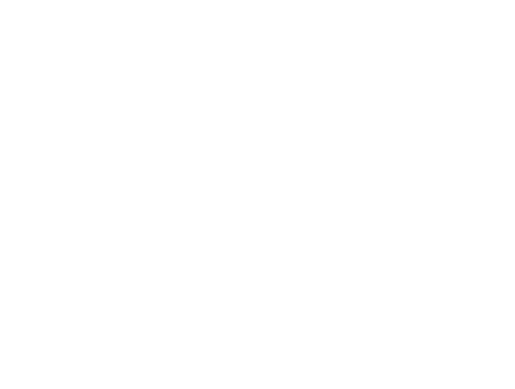

In [6]:
config['mode'] = 'latent'
run(config)

  0%|                                                                                     | 0/5001 [00:00<?, ?it/s]


Optimizing process:


RuntimeError: Trying to create tensor with negative dimension -17146298352: [-17146298352]

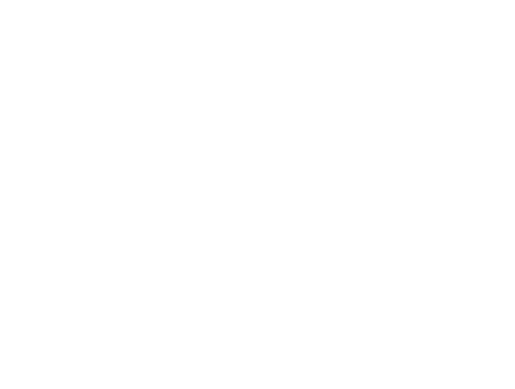

In [13]:
config['mode'] = 'rgb'
run(config)